# LSTM Without optimization

In [ ]:
!pip install mealpy
import nltk
from nltk.corpus import stopwords
import csv
from nltk.tag import pos_tag # for proper noun
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pandas as pd
import math
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_curve, roc_auc_score,auc
nltk.download('stopwords')
from mealpy.swarm_based.GWO import OriginalGWO
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten,LSTM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.0/378.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 82.1 MB/s eta 0:00:00


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
stop_words = set(stopwords.words('english'))

def preprocess(doc):
  doc = doc.replace('@', 'at')
  doc = doc.replace('\'', ' ')
  doc = doc.replace(',', ' ')
  doc = doc.replace('$', 'dollar')
  lst = []
  for token in doc.split():
    if token.lower() not in stop_words:
      lst.append(token)
  return ' '.join(lst)


In [ ]:
# Sample text summarization dataset

data = pd.read_excel("/content/Data1.xlsx")

# Create a DataFrame from the dataset
df = pd.DataFrame(data)

# Encode labels
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['Label'])

# Pre-processing the sentences
df['Sentences'] = df['Sentences'].apply(preprocess)

# Split the data into features and labels
X = df['Sentences']
y = df['label_encoded']

# Tokenize and pad sequences
max_words = 1000  # Define the maximum number of words to consider
max_sequence_length = 100  # Define the maximum sequence length

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences, maxlen=max_sequence_length)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(551, 100)

With Embedding layer

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=1000, output_dim=128, input_length=X_train.shape[1]))
model.add(LSTM(128))
model.add(Dense(1, activation='softmax'))



Without Embedding layer

In [ ]:
#model = Sequential()
#model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))  # Note the input_shape
#model.add(Dense(1, activation='sigmoid'))


In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")

5/5 [==============================] - 0s 44ms/step - loss: 0.5649 - accuracy: 0.7681
Test loss: 0.5649, Test accuracy: 0.7681


5/5 [==============================] - 0s 24ms/step
ROC AUC: 0.46875


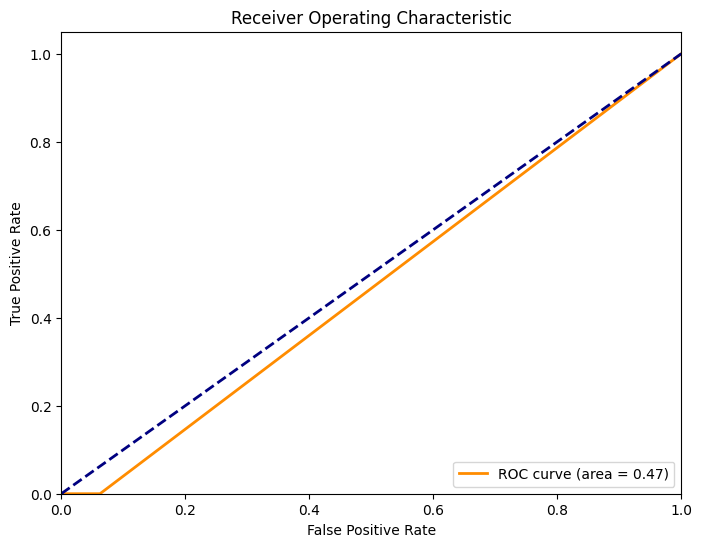

In [ ]:
# Predict probabilities on the test data
y_pred_prob = model.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()



# LSTM with GWO optmization

In [ ]:
# Split the dataset into training and testing sets
X = X
y = y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(X_train.shape)

(689, 100)
(551, 100)


In [ ]:
from mealpy.swarm_based.GWO import OriginalGWO
from sklearn.model_selection import StratifiedKFold
# Define the objective function (accuracy on the validation set)
def fitness_function(params):
    lstm_units= params
    lstm_units=int(lstm_units)
    # Create and compile your LSTM model with the given hyperparameters
    model = Sequential()
    model.add(Embedding(input_dim=1000, output_dim=128, input_length=X_train.shape[1]))
    model.add(LSTM(lstm_units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train and evaluate the model
    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)
    _, val_accuracy = model.evaluate(X_test, y_test)  # Replace with your validation data

    return val_accuracy  # Minimize the negative validation accuracy


problem_dict1 = {

    "fit_func": fitness_function,
    'lb':[1], # Lower bound of our parameters
    'ub':[2], # upper bound of our parameters
    "minmax": "min"
    }


epoch = 2
pop_size = 10
gwo= OriginalGWO(epoch, pop_size)
best_position, best_fitness = gwo.solve(problem_dict1)
print(f"Solution: {best_position}, Fitness: {best_fitness}")



5/5 [==============================] - 0s 5ms/step - loss: 0.6563 - accuracy: 0.7681


INFO:mealpy.swarm_based.GWO.OriginalGWO:Solving single objective optimization problem.


5/5 [==============================] - 0s 6ms/step - loss: 0.6666 - accuracy: 0.7681


INFO:mealpy.swarm_based.GWO.OriginalGWO:>Problem: P, Epoch: 1, Current best: 0.760869562625885, Global best: 0.760869562625885, Runtime: 30.99507 seconds


5/5 [==============================] - 0s 6ms/step - loss: 0.6803 - accuracy: 0.7681


INFO:mealpy.swarm_based.GWO.OriginalGWO:>Problem: P, Epoch: 2, Current best: 0.760869562625885, Global best: 0.760869562625885, Runtime: 30.04035 seconds


Solution: [1.54975796], Fitness: 0.760869562625885


In [ ]:
# # Define a function to optimize
# def train_and_evaluate_lstm(hyperparameters):
#     lstm_units = int(hyperparameters[0])
#     dropout_rate = hyperparameters[1]

#     model = tf.keras.Sequential([
#         tf.keras.layers.Embedding(input_dim=X_train.shape[1], output_dim=128, input_length=1000),
#         tf.keras.layers.LSTM(lstm_units),
#         tf.keras.layers.Dropout(dropout_rate),
#         tf.keras.layers.Dense(1, activation='sigmoid')
#     ])

#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#     model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2, verbose=0)

#     _, validation_accuracy = model.evaluate(X_test, y_test)

#     return validation_accuracy

# # Initialize the GWO optimizer
# problem_dict1 = {

#     "fit_func": train_and_evaluate_lstm,
#     'lb':[16,0.6], # Lower bound of our parameters
#     'ub':[18,0.5], # upper bound of our parameters
#     "minmax": "min"
#     }


# #gwo= OriginalGWO(epoch, pop_size)
# #best_position, best_fitness = gwo.solve(problem_dict1)
# #print(f"Solution: {best_position}, Fitness: {best_fitness}")

# epoch = 2
# pop_size = 10
# # Perform the GWO optimization

# gwo= OriginalGWO(epoch, pop_size)
# best_hyperparameters, best_performance = gwo.solve(problem_dict1)

# # Print the best hyperparameters and their corresponding performance
# print("Best Hyperparameters:", best_hyperparameters)
# print("Best Performance (Validation Accuracy):", best_performance)

In [ ]:
# Define K-Fold parameters
num_folds = 3  # Number of folds for cross-validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
epochs=1
batch_size=32
# Initialize a list to store validation accuracies and optmized hyper parameter

validation_accuracies = []
#best_lstm_units=int(best_position[0])
best_lstm_units=2 # assuming because optmization didnot run
# K-Fold cross-validation loop
for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    # Compile the same LSTM model with optmizied parameter
    final_model_GWO = Sequential()
    final_model_GWO.add(Embedding(input_dim=1000, output_dim=128, input_length=X_train.shape[1]))
    final_model_GWO.add(LSTM(best_lstm_units))
    final_model_GWO.add(Dense(1, activation='sigmoid'))
    final_model_GWO.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model for this fold
    final_model_GWO.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    # Evaluate the model on the validation set for this fold
    _, val_accuracy = final_model_GWO.evaluate(X_val, y_val)
    validation_accuracies.append(val_accuracy)

# Calculate and print the average validation accuracy across folds
average_validation_accuracy = np.mean(validation_accuracies)
print(f"Average Validation Accuracy: {average_validation_accuracy}")


Fold 1/3
8/8 [==============================] - 0s 5ms/step - loss: 0.6215 - accuracy: 0.7478
Fold 2/3
8/8 [==============================] - 0s 6ms/step - loss: 0.6701 - accuracy: 0.7435
Fold 3/3
8/8 [==============================] - 0s 6ms/step - loss: 0.6635 - accuracy: 0.7511
Average Validation Accuracy: 0.7474653522173563


5/5 [==============================] - 0s 7ms/step
ROC AUC: 0.8434551886792453


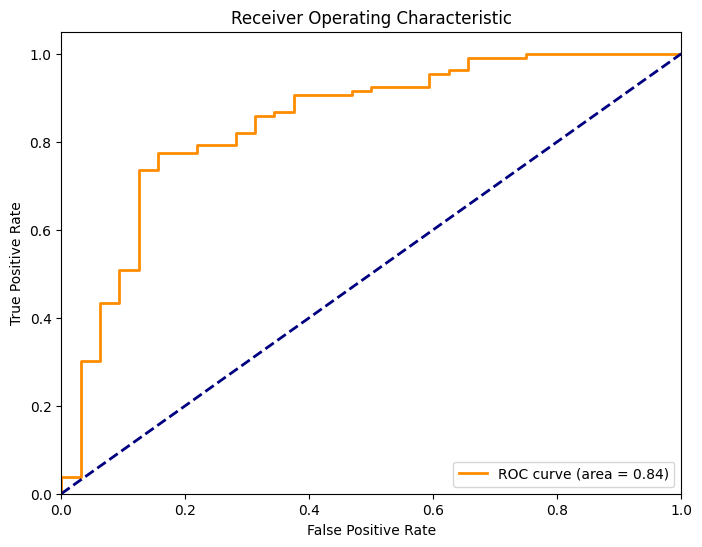

In [ ]:
# Predict probabilities on the test data
y_pred_prob = final_model_GWO.predict(X_test)

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print("ROC AUC:", roc_auc)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# LSTM with Genetic algorithms


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from mealpy.evolutionary_based.GA import BaseGA

# Split the data into train and test sets
X = X
y = y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)

(551, 100)


In [ ]:
# Define the objective function (negative accuracy on the validation set)
def fitness_function(params):
    lstm_units = int(params[0])
    # Create and compile your LSTM model with the given hyperparameters
    model = Sequential()
    model.add(Embedding(input_dim=1000, output_dim=128, input_length=X_train.shape[1]))
    model.add(LSTM(lstm_units))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train and evaluate the model
    model.fit(X_train, y_train, epochs=1, batch_size=32, validation_split=0.2)
    _, val_accuracy = model.evaluate(X_test, y_test)  # Replace with your validation data

    return val_accuracy  # Minimize the negative validation accuracy

problem_dict1 = {
    "fit_func": fitness_function,
    'lb': [32],  # Lower bound of lstm_units
    'ub': [128],  # Upper bound of lstm_units
    "minmax": "min"
}

epoch = 2

pop_size = 10

GA = BaseGA(epoch, pop_size)

best_position, best_fitness = GA.solve(problem_dict1)

print(f"Solution: {best_position}, Fitness: {best_fitness}")

5/5 [==============================] - 0s 21ms/step - loss: 0.5640 - accuracy: 0.7681


INFO:mealpy.evolutionary_based.GA.BaseGA:Solving single objective optimization problem.


5/5 [==============================] - 0s 17ms/step - loss: 0.5278 - accuracy: 0.7681


INFO:mealpy.evolutionary_based.GA.BaseGA:>Problem: P, Epoch: 1, Current best: 0.7681159377098083, Global best: 0.7681159377098083, Runtime: 38.07188 seconds


5/5 [==============================] - 0s 11ms/step - loss: 0.5601 - accuracy: 0.7681


INFO:mealpy.evolutionary_based.GA.BaseGA:>Problem: P, Epoch: 2, Current best: 0.7681159377098083, Global best: 0.7681159377098083, Runtime: 34.81656 seconds


Solution: [112.41964309], Fitness: 0.7681159377098083


# Define K-Fold parameters

In [ ]:
num_folds = 3  # Number of folds for cross-validation
kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)
epochs=1
batch_size=32
# Initialize a list to store validation accuracies and optmized hyper parameter

validation_accuracies = []
best_lstm_units=int(best_position[0])
#best_lstm_units=2 # assuming because optmization didnot run
# K-Fold cross-validation loop
for fold, (train_indices, val_indices) in enumerate(kfold.split(X, y)):
    print(f"Fold {fold + 1}/{num_folds}")

    # Split the data into training and validation sets for this fold
    X_train, X_val = X[train_indices], X[val_indices]
    y_train, y_val = y[train_indices], y[val_indices]

    # Compile the same LSTM model with optmizied parameter
    final_model_GA = Sequential()
    final_model_GA.add(Embedding(input_dim=1000, output_dim=128, input_length=X_train.shape[1]))
    final_model_GA.add(LSTM(best_lstm_units))
    final_model_GA.add(Dense(1, activation='sigmoid'))
    final_model_GA.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model for this fold
    final_model_GA.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

    # Evaluate the model on the validation set for this fold
    _, val_accuracy = final_model_GA.evaluate(X_val, y_val)
    validation_accuracies.append(val_accuracy)

# Calculate and print the average validation accuracy across folds
average_validation_accuracy = np.mean(validation_accuracies)
print(f"Average Validation Accuracy: {average_validation_accuracy}")

Fold 1/3
8/8 [==============================] - 0s 41ms/step - loss: 0.5687 - accuracy: 0.7478
Fold 2/3
8/8 [==============================] - 0s 23ms/step - loss: 0.5686 - accuracy: 0.7435
Fold 3/3
8/8 [==============================] - 0s 26ms/step - loss: 0.5606 - accuracy: 0.7467
Average Validation Accuracy: 0.7460097471872965


5/5 [==============================] - 0s 6ms/step
ROC AUC via GA: 0.8160377358490565
ROC AUC via GWO: 0.8434551886792453


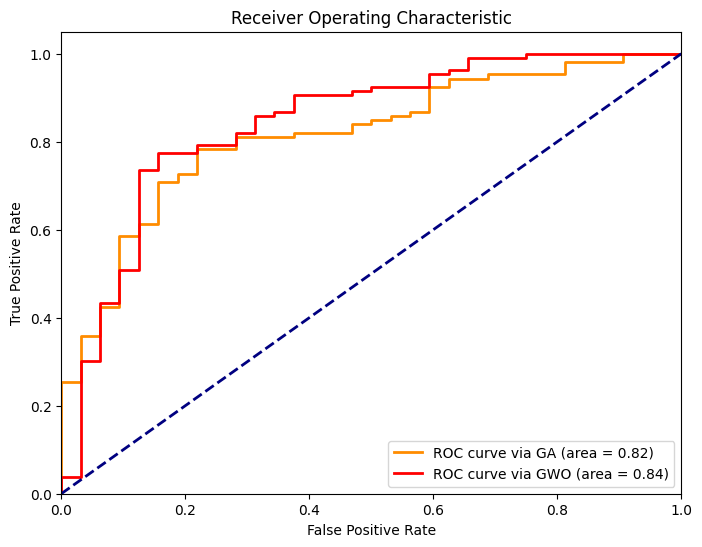

In [ ]:
# Predict probabilities on the test data
y_pred_prob_GA = final_model_GA.predict(X_test)
y_pred_prob_GWO= final_model_GWO.predict(X_test)

# Calculate ROC curve and AUC
fpr_GA, tpr_GA, thresholds_GA = roc_curve(y_test, y_pred_prob_GA)
fpr_GWO,tpr_GWO,thresholds_GWO=roc_curve(y_test,y_pred_prob_GWO)
roc_auc_GA = auc(fpr_GA, tpr_GA)
roc_auc_GWO = auc(fpr_GWO,tpr_GWO)

print("ROC AUC via GA:", roc_auc_GA)
print("ROC AUC via GWO:", roc_auc_GWO)


# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_GA, tpr_GA, color='darkorange', lw=2, label='ROC curve via GA (area = %0.2f)' % roc_auc_GA)
plt.plot(fpr_GWO, tpr_GWO, color='red', lw=2, label='ROC curve via GWO (area = %0.2f)' % roc_auc_GWO)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()
